In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='Glyph.*missing from font')

In [3]:
routes_df = pd.DataFrame({
    "route_code": [
#        "2HM2+P8|XJV5+RG",     # Jaya Prakash Narayana Park → Coles Park, Fraser Town
        "VJRQ+2M|RMJJ+F4",     # Kudlu Gate Metro Station → Biocon Campus
        "WH5F+26|WJ8X+F5W",    # Jaya Prakash Nagar Metro Station → Hemavathi Park, HSR Layout
        "XJPW+92|WJP4+FF",     # Swami Vivekananda Road Metro Station → Christ University, Hosur Main Road
        "2HVW+G8|XJXR+WG",     # Bethel AG Church, Hebbal → SMVT Railway Station
        "WGG8+G5|XH7P+G6",     # The Watering Hole, Rajarajeshwari Nagar → Sir Puttanna Chetty Town Hall, Bangalore
        "XPC7+72|XM33+J3",     # The Rameshwaram Cafe @ Brookfield → Gawky Goose, Wind Tunnel Rd
        "WHCJ+26|XGCP+FV",     # RV Road Metro Station, Jayanagar 5th Block → Vijayanagar Metro Station, Chord Road
        "XMW9+G8|WMJR+V4",     # Benniganahalli Metro Station → Embassy TechVillage, Devarabisanahalli
#        "XHJ7+MG|WJM6+VC",     # Lulu Mall Bengaluru → Nexus Mall Koramangala
#        "WHR9+R6|XJGF+6J",     # Big Bull Temple, Basavanagudi → Shri Someshwara Swamy Temple, Halasuru
#        "WP44+W8|WJFH+XQ",     # Karmelaram Railway Station, Chikkabellandur → St. Francis College, Koramangala
#        "XJG4+7J|5PX4+HQ",     # MG Road Metro Station → Kempegowda International Airport, Bengaluru
]})

routes_df = routes_df.merge(pd.read_csv("csv-routes.csv"), on='route_code', how='left')

# Canonical, deterministic order: alphabetical route_code
routes = sorted(routes_df['route_code'].dropna().unique())

# Stable palette and mapping
palette = sns.color_palette("tab20", n_colors=len(routes))
assigned_colours = dict(zip(routes, palette))

# Persist colors in routes_df
routes_df['color_hex'] = routes_df['route_code'].map(assigned_colours).map(mcolors.to_hex)

display(routes_df)

,route_code,label_full,label_short,color_hex
0,VJRQ+2M|RMJJ+F4,Kudlu Gate Metro Station → Biocon Campus,Hosur Road,#aec7e8
1,WH5F+26|WJ8X+F5W,Jaya Prakash Nagar Metro Station → Hemavathi P...,Double Decker Flyover,#ffbb78
2,XJPW+92|WJP4+FF,Swami Vivekananda Road Metro Station → Christ ...,East Inner Ring,#98df8a
3,2HVW+G8|XJXR+WG,"Bethel AG Church, Hebbal → SMVT Railway Station",North Outer Ring,#1f77b4
4,WGG8+G5|XH7P+G6,"The Watering Hole, Rajarajeshwari Nagar → Sir ...",Mysore Road,#ff7f0e
5,XPC7+72|XM33+J3,The Rameshwaram Cafe @ Brookfield → Gawky Goos...,Old Airport Road,#ff9896
6,WHCJ+26|XGCP+FV,"RV Road Metro Station, Jayanagar 5th Block → V...",South Outer Ring,#2ca02c
7,XMW9+G8|WMJR+V4,Benniganahalli Metro Station → Embassy TechVil...,East Outer Ring,#d62728


![routes.png](routes.png)

In [4]:
locations = pd.read_csv("csv-locations_12.9514242_77.6590212.csv").to_dict(orient='list')
locate = lambda plus_code: locations['location'][locations['plus_code'].index(plus_code)]

master_df = pd.read_csv("csv-bangalore_traffic.csv")
display(master_df)

,date,time,route_code,duration,distance
0,2025-09-25,14:25,2HM2+P8|XJV5+RG,32,11.0
1,2025-09-25,14:25,XJG4+7J|5PX4+HQ,60,34.3
2,2025-09-25,14:25,VJRQ+2M|RMJJ+F4,23,10.3
3,2025-09-25,14:25,WH5F+26|WJ8X+F5W,25,10.2
4,2025-09-25,14:25,XJPW+92|WJP4+FF,38,10.4
...,...,...,...,...,...
4111,2025-10-10,05:11,WHCJ+26|XGCP+FV,22,10.6
4112,2025-10-10,05:11,WH5F+26|WJ8X+F5W,17,10.2
4113,2025-10-10,05:11,XHJ7+MG|WJM6+VC,19,10.5
4114,2025-10-10,05:11,WHR9+R6|XJGF+6J,21,10.1


In [5]:
def transformed_data(df_in):
    df_traffic = df_in.copy()
    df_traffic['year'] = pd.to_datetime(df_traffic['date']).dt.year
    df_traffic['month'] = pd.to_datetime(df_traffic['date']).dt.month
    df_traffic['day'] = pd.to_datetime(df_traffic['date']).dt.day
    df_traffic['hour'] = pd.to_datetime(df_traffic['time'], format='%H:%M', errors='coerce').dt.hour
    df_traffic['day_of_week'] = pd.to_datetime(df_traffic['date']).dt.day_name()
    df_traffic['avg_speed'] = round(df_traffic['distance'] / (df_traffic['duration'] / 60), 2)
    df_traffic = df_traffic[['year', 'month', 'day', 'hour', 'route_code', 
#    'label_full', 'label_short', 
    'duration', 'distance', 'avg_speed']]
    df_traffic = df_traffic.sort_values(['year', 'month', 'day', 'hour', 'avg_speed'],\
                                ascending=[True, True, True, True, False]).reset_index(drop=True)
    return df_traffic

# Keep only those rows of master_df that correspond to selected routes
df = master_df.merge(routes_df, on='route_code')
df = transformed_data(df)
display(df)

,year,month,day,hour,route_code,duration,distance,avg_speed
0,2025,9,25,14,VJRQ+2M|RMJJ+F4,23,10.3,26.87
1,2025,9,25,14,WH5F+26|WJ8X+F5W,25,10.2,24.48
2,2025,9,25,14,XMW9+G8|WMJR+V4,26,10.1,23.31
3,2025,9,25,14,XPC7+72|XM33+J3,27,9.4,20.89
4,2025,9,25,14,2HVW+G8|XJXR+WG,31,9.9,19.16
...,...,...,...,...,...,...,...,...
2565,2025,10,10,5,XPC7+72|XM33+J3,16,9.4,35.25
2566,2025,10,10,5,WGG8+G5|XH7P+G6,18,10.4,34.67
2567,2025,10,10,5,XJPW+92|WJP4+FF,18,10.1,33.67
2568,2025,10,10,5,WHCJ+26|XGCP+FV,22,10.6,28.91


In [6]:
display(df.describe().round(2))
display(df.describe(exclude='number'))
display(df['route_code'].value_counts())

,year,month,day,hour,duration,distance,avg_speed
count,2570.0,2570.00,2570.00,2570.00,2570.00,2570.00,2570.00
mean,2025.0,9.66,12.83,11.74,25.54,10.19,26.49
std,0.0,0.47,10.98,7.03,8.46,0.46,8.18
min,2025.0,9.00,1.00,0.00,13.00,9.20,11.02
25%,2025.0,9.00,4.00,5.00,19.00,9.90,19.45
50%,2025.0,10.00,7.00,12.00,24.00,10.20,25.68
75%,2025.0,10.00,27.00,18.00,32.00,10.40,32.53
max,2025.0,10.00,30.00,23.00,55.00,13.60,47.54


,route_code
count,2570
unique,8
top,VJRQ+2M|RMJJ+F4
freq,337


route_code
VJRQ+2M|RMJJ+F4     337
WH5F+26|WJ8X+F5W    337
XMW9+G8|WMJR+V4     337
XPC7+72|XM33+J3     337
2HVW+G8|XJXR+WG     337
WHCJ+26|XGCP+FV     337
XJPW+92|WJP4+FF     337
WGG8+G5|XH7P+G6     211
Name: count, dtype: int64

In [7]:
df_minmax = df.merge(routes_df, on='route_code').copy()

df_minmax = df_minmax.groupby(['label_short', 'hour'])['avg_speed'].mean().unstack().reset_index()
df_minmax['mean_avg_speed'] = df_minmax.iloc[:, 1:].apply(lambda row: row.mean(), axis=1)
df_minmax['max_hour'] = df_minmax.iloc[:, 1:-1].apply(lambda row: row.idxmax(), axis=1)
df_minmax['min_hour'] = df_minmax.iloc[:, 1:-2].apply(lambda row: row.idxmin(), axis=1)

df_minmax[['label_short', 'max_hour', 'min_hour', 'mean_avg_speed']].\
    sort_values(by='mean_avg_speed', ascending=False).reset_index(drop=True)

hour,label_short,max_hour,min_hour,mean_avg_speed
0,Hosur Road,3,18,32.454520
1,East Outer Ring,5,17,30.319022
2,Double Decker Flyover,4,18,29.233451
3,Old Airport Road,4,18,25.634199
4,Mysore Road,3,19,25.198242
5,East Inner Ring,3,18,23.168121
6,North Outer Ring,4,18,22.842876
7,South Outer Ring,3,18,21.797814


In [31]:
def fill_and_smooth_route(df, timeline):
    """
    Aggregate duplicate timestamps, reindex to a common timeline, fill missing values, and smooth the speed data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Route-specific data with columns: timestamp, route_code, route_label, duration, distance, avg_speed
    timeline : pd.Index
        Common timeline (all unique timestamps across all routes) to reindex to
    
    Returns
    -------
    pd.DataFrame
        DataFrame with filled and smoothed speed data for all timestamps in the timeline
    """
    # Aggregate duplicate timestamps (take mean of numeric values)
    df_agg = df.groupby('timestamp', as_index=False).agg({
        'route_code': 'first',
        'route_label': 'first',
        'duration': 'mean',
        'distance': 'mean',
        'avg_speed': 'mean'
    })
    
    # Reindex to common timeline and fill missing values
    g = df_agg.set_index('timestamp').reindex(timeline)
    
    # Fill missing speeds using neighbor averaging
    speeds = pd.to_numeric(g['avg_speed'], errors='coerce')
    prev_vals = speeds.ffill()
    next_vals = speeds.bfill()
    
    mask_missing = speeds.isna()
    mask_both = mask_missing & prev_vals.notna() & next_vals.notna()
    mask_prev_only = mask_missing & prev_vals.notna() & next_vals.isna()
    mask_next_only = mask_missing & next_vals.notna() & prev_vals.isna()
    
    filled = speeds.copy()
    filled.loc[mask_both] = (prev_vals.loc[mask_both] + next_vals.loc[mask_both]) / 2.0
    filled.loc[mask_prev_only] = prev_vals.loc[mask_prev_only]
    filled.loc[mask_next_only] = next_vals.loc[mask_next_only]
    
    g['speed_filled'] = filled
    
    # Apply smoothing to filled speeds
    speed_series = g['speed_filled']
    mask_valid = speed_series.notna()
    
    if mask_valid.sum() < 3:
        # Not enough data points to smooth
        g['speed_smooth'] = speed_series
    else:
        try:
            from scipy.interpolate import PchipInterpolator
            
            ts_valid = g.index[mask_valid]
            speed_valid = speed_series[mask_valid]
            
            # Convert timestamps to ordinal for interpolation
            x = ts_valid.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
            y = speed_valid.to_numpy(dtype=float)
            x_all = g.index.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
            
            interp = PchipInterpolator(x, y)
            g['speed_smooth'] = pd.Series(interp(x_all), index=g.index)
        except Exception:
            # Fallback: centered rolling mean
            win = 3 if mask_valid.sum() < 10 else 5
            g['speed_smooth'] = speed_series.rolling(window=win, center=True, min_periods=1).mean()
    
    return g.reset_index(names='timestamp')


def plot_traffic_square(df_incoming, days_offset=1, height='square', label='short', dpi=300):
    """
    Plot smoothed average speed over time for multiple traffic routes.
    
    Creates a time-series line plot showing traffic speeds across different routes,
    with automatic gap filling, smoothing, and visual markers for day boundaries.
    
    Parameters
    ----------
    df_incoming : pd.DataFrame
        Traffic data with columns:
        - year, month, day, hour : int, datetime components
        - route_code : str, unique route identifier
        - label_short, label_full : str, route display names
        - duration : numeric, travel time in minutes
        - distance : numeric, route distance in km
        - avg_speed : numeric, average speed in km/h
    days_offset : int or float, default=1
        Number of days of historical data to plot (from most recent timestamp)
    height : str, default='square'
        Figure layout preset:
        - 'square': 14x14, hourly ticks, fontsize 12
        - 'wide': 20x14, 3-hour ticks, fontsize 14
        - 'extrawide': 26x14, 6-hour ticks, fontsize 16
        - 'extrawide2': 30x12, 6-hour ticks, fontsize 18
    label : str, default='short'
        Route label type to display in legend: 'short' or 'full'
    dpi : int, default=300
        Figure resolution (dots per inch)
    
    Returns
    -------
    pd.DataFrame
        The original input dataframe (unchanged)
    
    Notes
    -----
    - Missing timestamps are filled using neighbor averaging
    - Speed data is smoothed using PCHIP interpolation (or rolling mean as fallback)
    - Vertical lines mark midnight boundaries with day-of-week labels
    """
    # 1) Validate input parameters
    if df_incoming.empty:
        print("No data available in the dataset.")
        return df_incoming

    if label not in ['short', 'full']:
        print(f"label must be 'short' or 'full', got: {label}")
        return df_incoming

    size_configs = {
        'square': (14, 15, 1, 12),
        'wide': (20, 14, 3, 14),
        'extrawide': (26, 14, 6, 16),
        'extrawide2': (30, 12, 6, 18)
    }
    
    if height not in size_configs:
        raise ValueError(f"height must be one of {list(size_configs.keys())}, got: {height}")
    
    # 2) Prepare data
    df_plot = df_incoming.merge(routes_df, on='route_code').copy()
    df_plot['route_label'] = df_plot['label_' + label]
    
    # Create timestamp and filter by time window
    df_plot['timestamp'] = pd.to_datetime(df_plot[['year', 'month', 'day', 'hour']])
    HOURS_OFFSET = df_plot['timestamp'].max() - timedelta(hours=int(days_offset * 24))
    df_plot = df_plot[df_plot['timestamp'] >= HOURS_OFFSET]
    
    # Keep only necessary columns
    df_plot = df_plot[['timestamp', 'route_code', 'route_label', 'color_hex', 'duration', 'distance', 'avg_speed']]

    # 3) Build common timeline and process routes
    timeline = pd.Index(sorted(df_plot['timestamp'].unique()))
    
    frames = []
    for route in sorted(df_plot['route_code'].unique()):
        route_data = df_plot[df_plot['route_code'] == route]
        frames.append(fill_and_smooth_route(route_data, timeline))
    
    df_filled = pd.concat(frames, ignore_index=True).sort_values(['timestamp', 'route_code'])

    # 4) Determine figure size based on height parameter
    fig_width, fig_height, hour_interval, legend_fontsize = size_configs[height]
    
    # 5) Create plot
    # canonical hue order (alphabetical codes used when colors were assigned)
    hue_order = sorted(routes_df['route_code'].dropna().unique())
    # palette dict: code -> color (hex or rgb both OK)
    palette = routes_df.set_index('route_code')['color_hex'].reindex(hue_order).to_dict()

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    
    sns.lineplot(
        data=df_filled,
        x='timestamp', 
        y='speed_smooth',
        hue='route_code',
        hue_order=hue_order,
        palette=palette,
        linewidth=8, alpha=0.4, ax=ax)
    
    # Configure axes
    ax.grid(True, which='both', linestyle='--', linewidth=0.4)
    ax.margins(x=0)
    ax.set_xlim(df_filled['timestamp'].min(), df_filled['timestamp'].max())
    ax.tick_params(axis='both', labelsize=legend_fontsize)
    
    # Format x-axis as hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
    ax.set_xlabel('TIME (HOUR)', fontsize=legend_fontsize + 2)
    ax.set_ylabel('AVERAGE SPEED (KM/H)', fontsize=legend_fontsize + 2)
    
    # Dynamic title
    start = df_filled['timestamp'].min()
    end = df_filled['timestamp'].max()
    time_range_hours = (end - start).total_seconds() / 3600
    ax.set_title(f'Average Speeds Over Last {time_range_hours:.0f} Hours', 
                 fontsize=legend_fontsize + 2, fontweight='bold')
    
    # Mark midnight boundaries with day labels
    ylim = ax.get_ylim()
    midnight_times = pd.date_range(
        start=start.normalize() + pd.Timedelta(days=1),
        end=end,
        freq='D'
    )
    
    for midnight in midnight_times:
        ax.axvline(x=midnight, color='black', linewidth=1, linestyle='-', zorder=1)
        ax.text(
            midnight, ylim[1] * 0.98,
            midnight.strftime('%A'),
            ha='left',
            va='top',
            fontsize=legend_fontsize,
            fontweight='bold',
            color='black'
        )
    
    # Map route_code -> route_label for legend text
    code_to_label = (
        df_filled[['route_code', 'route_label']]
        .dropna()
        .drop_duplicates('route_code')
        .set_index('route_code')['route_label']
        .to_dict()
    )

    # Get legend from seaborn
    handles, labels = ax.get_legend_handles_labels()
    if labels and labels[0] == 'route_code':  # drop seaborn hue title
        handles, labels = handles[1:], labels[1:]

    # Reorder to match hue_order and swap code -> label
    handle_by_code = dict(zip(labels, handles))
    ordered_handles = [handle_by_code[c] for c in hue_order if c in handle_by_code]
    ordered_labels  = [code_to_label.get(c, c) for c in hue_order if c in handle_by_code]

    # Always place legend below. Full labels => 1 column; else 2 columns
    ncols = 1 if label == 'full' else 2
    leg = ax.legend(
        ordered_handles, ordered_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.10),  # below the axes
        ncol=ncols,
        frameon=True,
        fontsize=legend_fontsize,
        borderpad=1.0,
        labelspacing=0.8
    )
    leg.get_frame().set_linewidth(0.8)
    leg.get_frame().set_edgecolor('#000000')

    # Make room at bottom depending on columns
    plt.subplots_adjust(bottom=0.32 if ncols == 1 else 0.24)
    plt.tight_layout()
    plt.show()
    
    return df_plot

In [9]:
def plot_route_boxplots(df_incoming, avg_speed=True, duration=True, legend=True, show_stats=True, label='short'):
    """
    Boxplots of route performance (avg speed and/or duration).

    - Colors are a single source of truth from `routes_df`, assigned by
      alphabetical route_code to keep consistency across all charts.
    - X order is by median avg_speed (fastest → slowest), but coloring
      is still tied to route_code so colors always match the line plot.
    - X tick labels display human-friendly route labels.
    - Optional: declutter sample sizes by showing a single common n when uniform,
      and only annotating (n=...) for exceptions.

    Parameters
    ----------
    df_incoming : pd.DataFrame
        Must include columns:
        - route_code (str)
        - route_label (str)
        - avg_speed (numeric, km/h)
        - duration (numeric, minutes)
    routes_df : pd.DataFrame
        Must include columns:
        - route_code (str)
        - color_hex (str hex color) assigned from an alphabetical palette
          e.g. created once via:
              routes = sorted(routes_df['route_code'].unique())
              palette = sns.color_palette("tab20", n_colors=len(routes))
              routes_df['color_hex'] = routes_df['route_code'].map(dict(zip(routes, palette))).map(mcolors.to_hex)
    avg_speed : bool, default=True
        Include the Average Speed boxplot.
    duration : bool, default=True
        Include the Duration boxplot.
    legend : bool, default=True
        If True, show x tick labels (rotated); otherwise hide them.
    show_stats : bool, default=True
        If True, annotate median values on each box.

    Returns
    -------
    None
        Displays matplotlib figure with the boxplot(s).
    """

    # 1) Validate input parameters
    if df_incoming.empty:
        print("No data available in the dataset.")
        return df_incoming

    if label not in ['short', 'full']:
        print(f"label must be 'short' or 'full', got: {label}")
        return df_incoming

    if not (avg_speed or duration):
        raise ValueError("At least one of avg_speed or duration must be True")

    df_box = df_incoming.merge(routes_df, on='route_code', how='left').copy()
    df_box['route_label'] = df_box['label_' + label]

    # Ensure required columns exist
    required_routes_cols = {'route_code', 'color_hex'}
    if not required_routes_cols.issubset(routes_df.columns):
        raise ValueError("routes_df must contain columns: route_code, color_hex")

    # Build metrics to plot
    metrics = {}
    if avg_speed:
        metrics['avg_speed'] = 'Average Speed (km/h)'
    if duration:
        metrics['duration'] = 'Duration (minutes)'

    # X display order: route_code sorted by median avg_speed (descending)
    if 'avg_speed' not in df_box.columns:
        raise ValueError("df_incoming must contain 'avg_speed' to order routes by speed")
    route_code_order = (
        df_box.groupby('route_code', sort=False)['avg_speed']
              .median()
              .sort_values(ascending=False)
              .index.tolist()
    )

    # Canonical hue order (alphabetical route_code) used for color mapping
    hue_order = sorted(routes_df['route_code'].dropna().unique())
    # Palette dict: code -> hex color (only for codes in hue_order)
    palette = routes_df.set_index('route_code')['color_hex'].to_dict()

    # Human-readable label lookup (for x tick labels)
    code_to_label = df_box.groupby('route_code')['route_label'].first().to_dict()
    route_label_order = [code_to_label.get(c, c) for c in route_code_order]

    # Figure size
    n_plots = len(metrics)
    fig_width = 14 if n_plots == 1 else 18
    fig_height = 12 if legend else 8
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, fig_height), sharex=False, dpi=300)
    if n_plots == 1:
        axes = [axes]

    for ax, (metric_key, metric_label) in zip(axes, metrics.items()):
        # Draw boxplot: color keyed by route_code (consistent with line plot)
        sns.boxplot(
            data=df_box,
            x='route_code', y=metric_key,
            order=route_code_order,
            hue='route_code',
            hue_order=hue_order,       # canonical alphabetical order
            palette=palette,           # dict: route_code -> hex
            dodge=False,
            legend=False,
            flierprops=dict(marker='o', markerfacecolor='red', markersize=4,
                            linestyle='none', markeredgecolor='darkred', alpha=0.6),
            ax=ax
        )

        # Make boxes/lines semi-transparent
        for patch in ax.artists:
            fc = patch.get_facecolor()
            patch.set_facecolor((*fc[:3], 0.4))
        for line in ax.lines:
            line.set_alpha(0.4)

        # Median annotations (by route_code to match x order)
        if show_stats:
            medians = df_box.groupby('route_code')[metric_key].median()
            for i, code in enumerate(route_code_order):
                m = medians.get(code)
                if pd.notna(m):
                    ax.text(i, m, f'{m:.1f}',
                            ha='center', va='bottom', fontsize=9, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                      alpha=0.85, edgecolor='gray', linewidth=0.5))

        # Axes formatting
        ax.set_xlabel('')
        ax.set_ylabel(metric_label.upper(), fontsize=13, fontweight='bold')
        ax.set_title(f'{metric_label} Distribution by Route\n(Ordered by Median Speed)',
                     fontsize=14, fontweight='bold', pad=15)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

        # Declutter n: show one common n if uniform, otherwise annotate only exceptions
        counts = df_box.groupby('route_code').size()
        all_same = counts.nunique() == 1
        common_n = (counts.iloc[0] if all_same else
                    (counts.mode().iat[0] if not counts.empty else None))

        # Replace codes with route labels on x-axis
        if legend:
            if all_same and common_n is not None:
                # Just labels (no per-route n), and one global note below
                labels = route_label_order
                ax.set_xticks(range(len(route_code_order)))
                ax.set_xticklabels(labels, rotation=90, ha='right', fontsize=10)
                ax.tick_params(axis='x', bottom=True)
                ax.annotate(f'n per route: {common_n}', xy=(0.5, -0.22),
                            xycoords='axes fraction', ha='center', va='top',
                            fontsize=10, color='dimgray')
            else:
                # Append (n=...) only for routes that deviate from common_n
                labels = []
                for code, base in zip(route_code_order, route_label_order):
                    c = counts.get(code, 0)
                    if common_n is None or c != common_n:
                        labels.append(f'{base} (n={c})')
                    else:
                        labels.append(base)
                ax.set_xticks(range(len(route_code_order)))
                ax.set_xticklabels(labels, rotation=90, ha='right', fontsize=10)
                ax.tick_params(axis='x', bottom=True)
        else:
            ax.tick_params(axis='x', labelbottom=False, bottom=False)

    plt.subplots_adjust(bottom=0.35 if legend else 0.1)
    plt.tight_layout()
    plt.show()

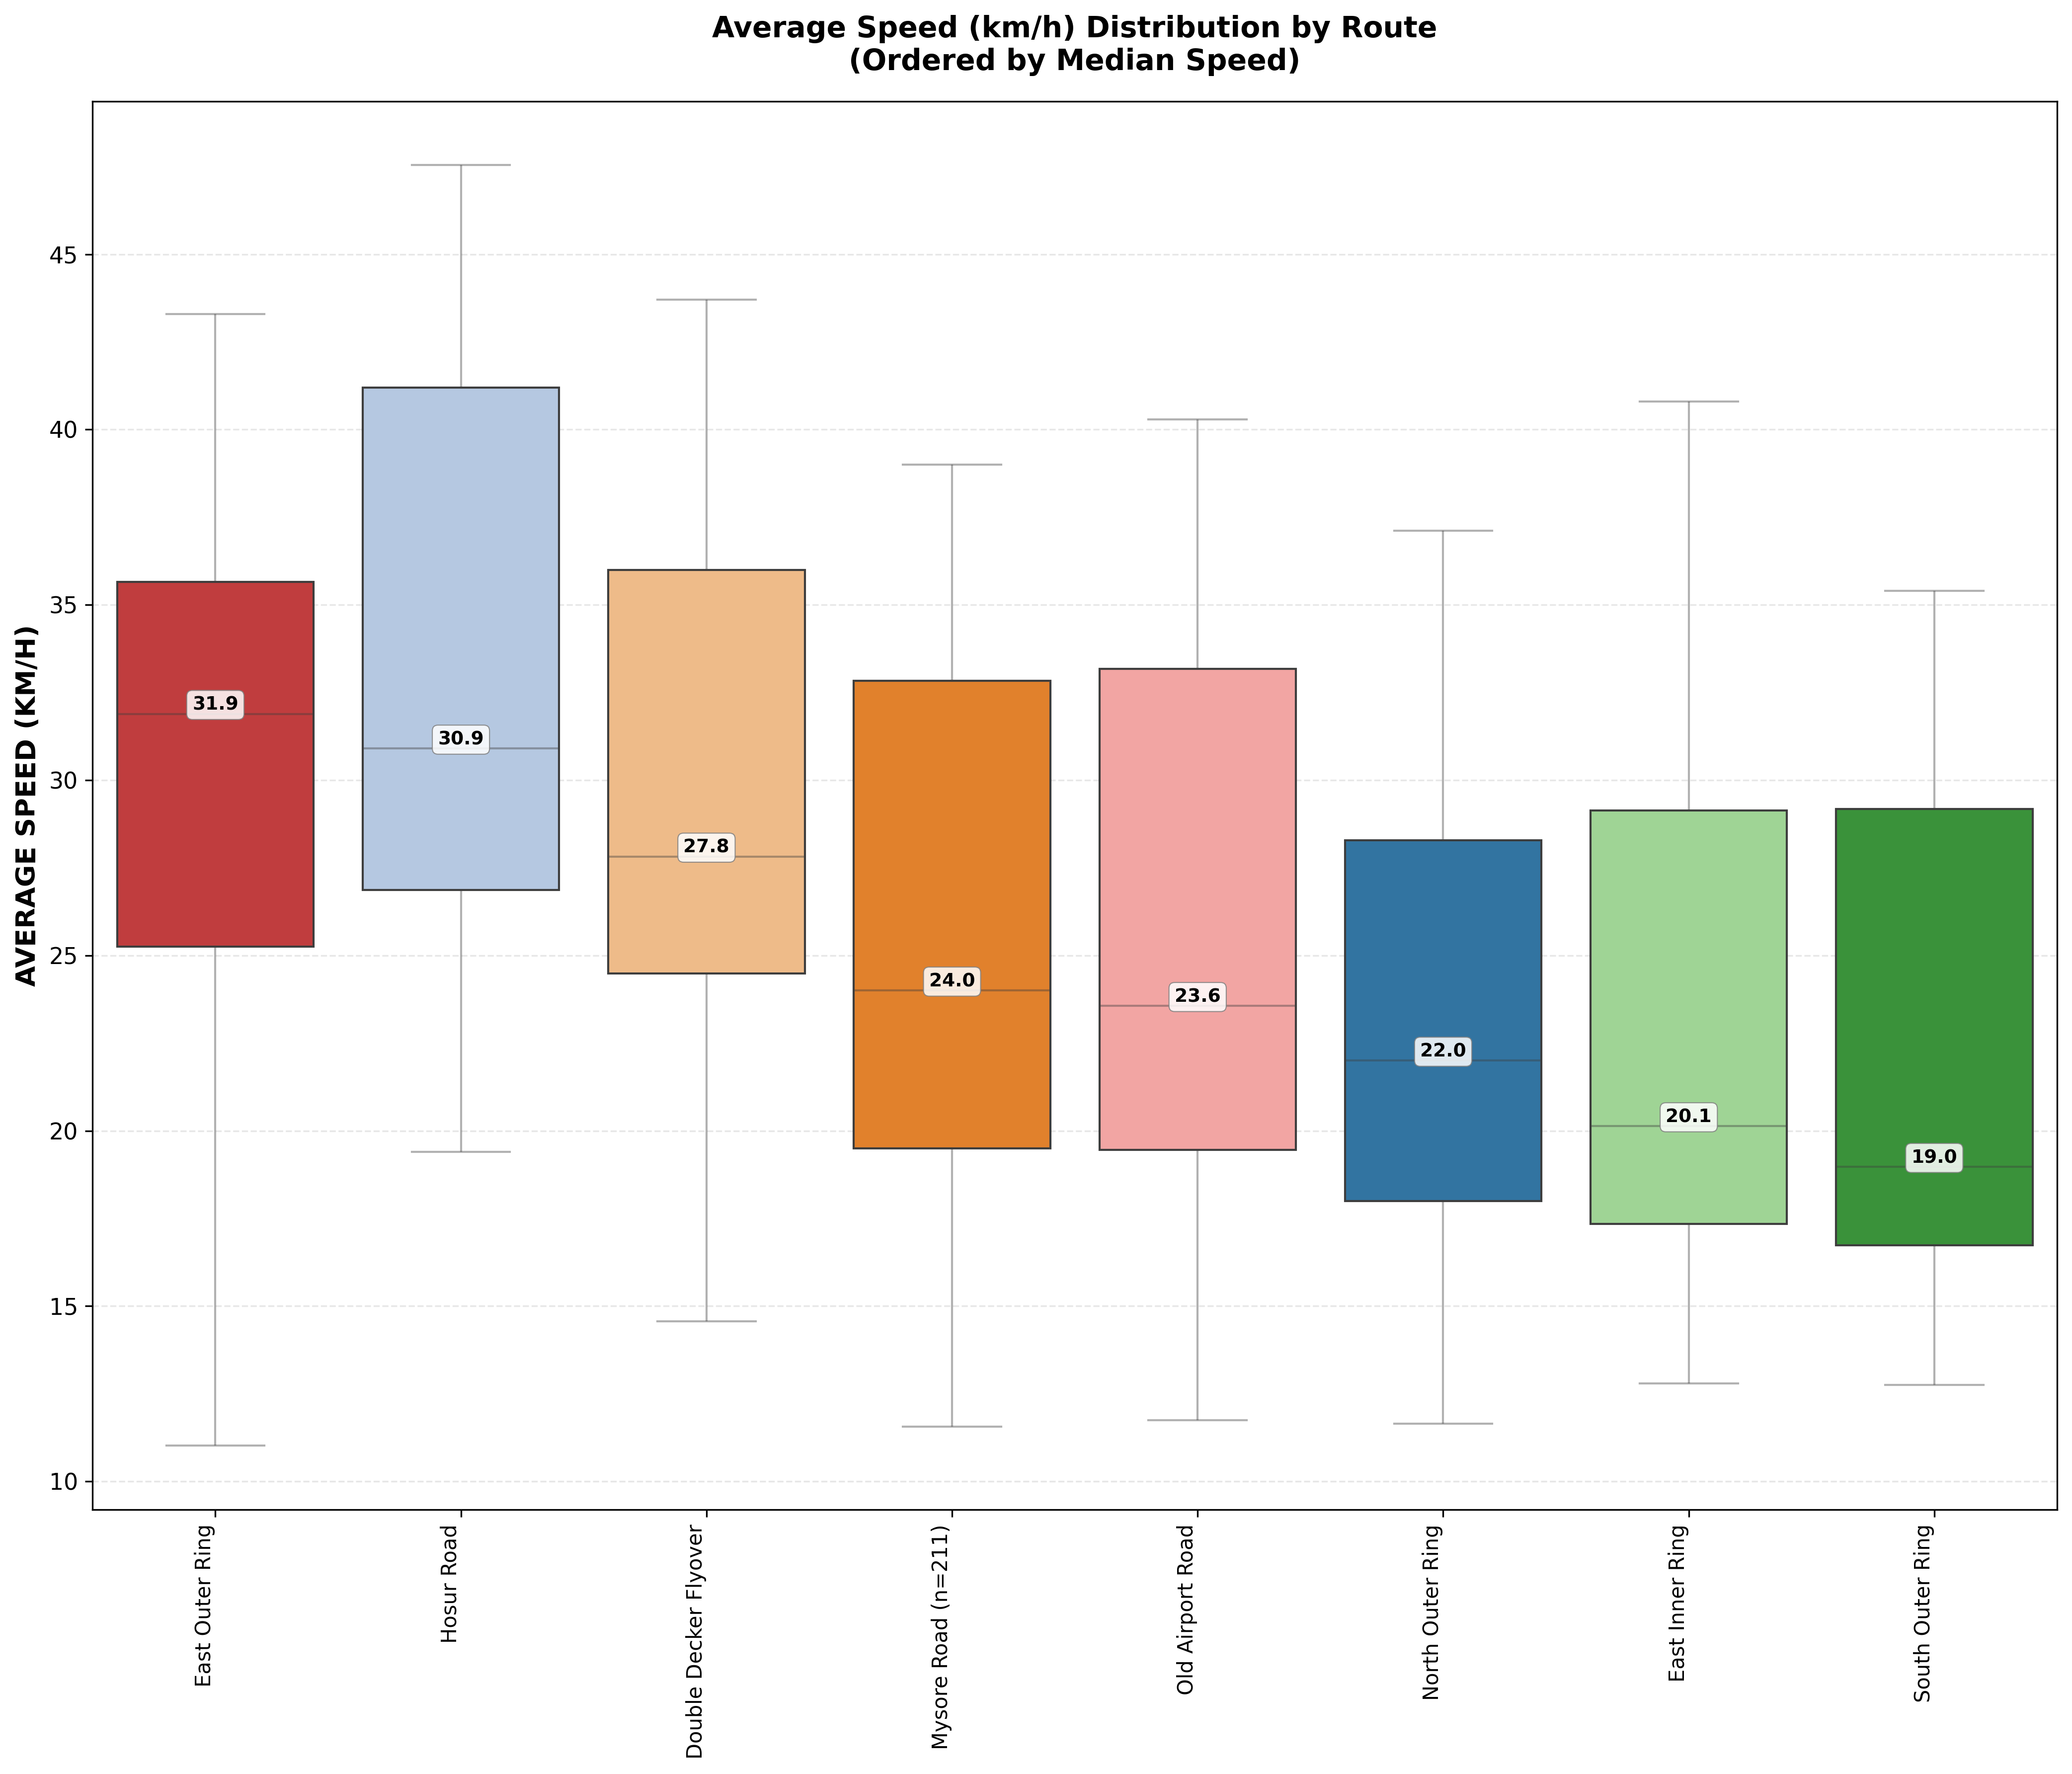

In [12]:
plot_route_boxplots(df, avg_speed=True, duration=False, legend=True, show_stats=True, label='short')

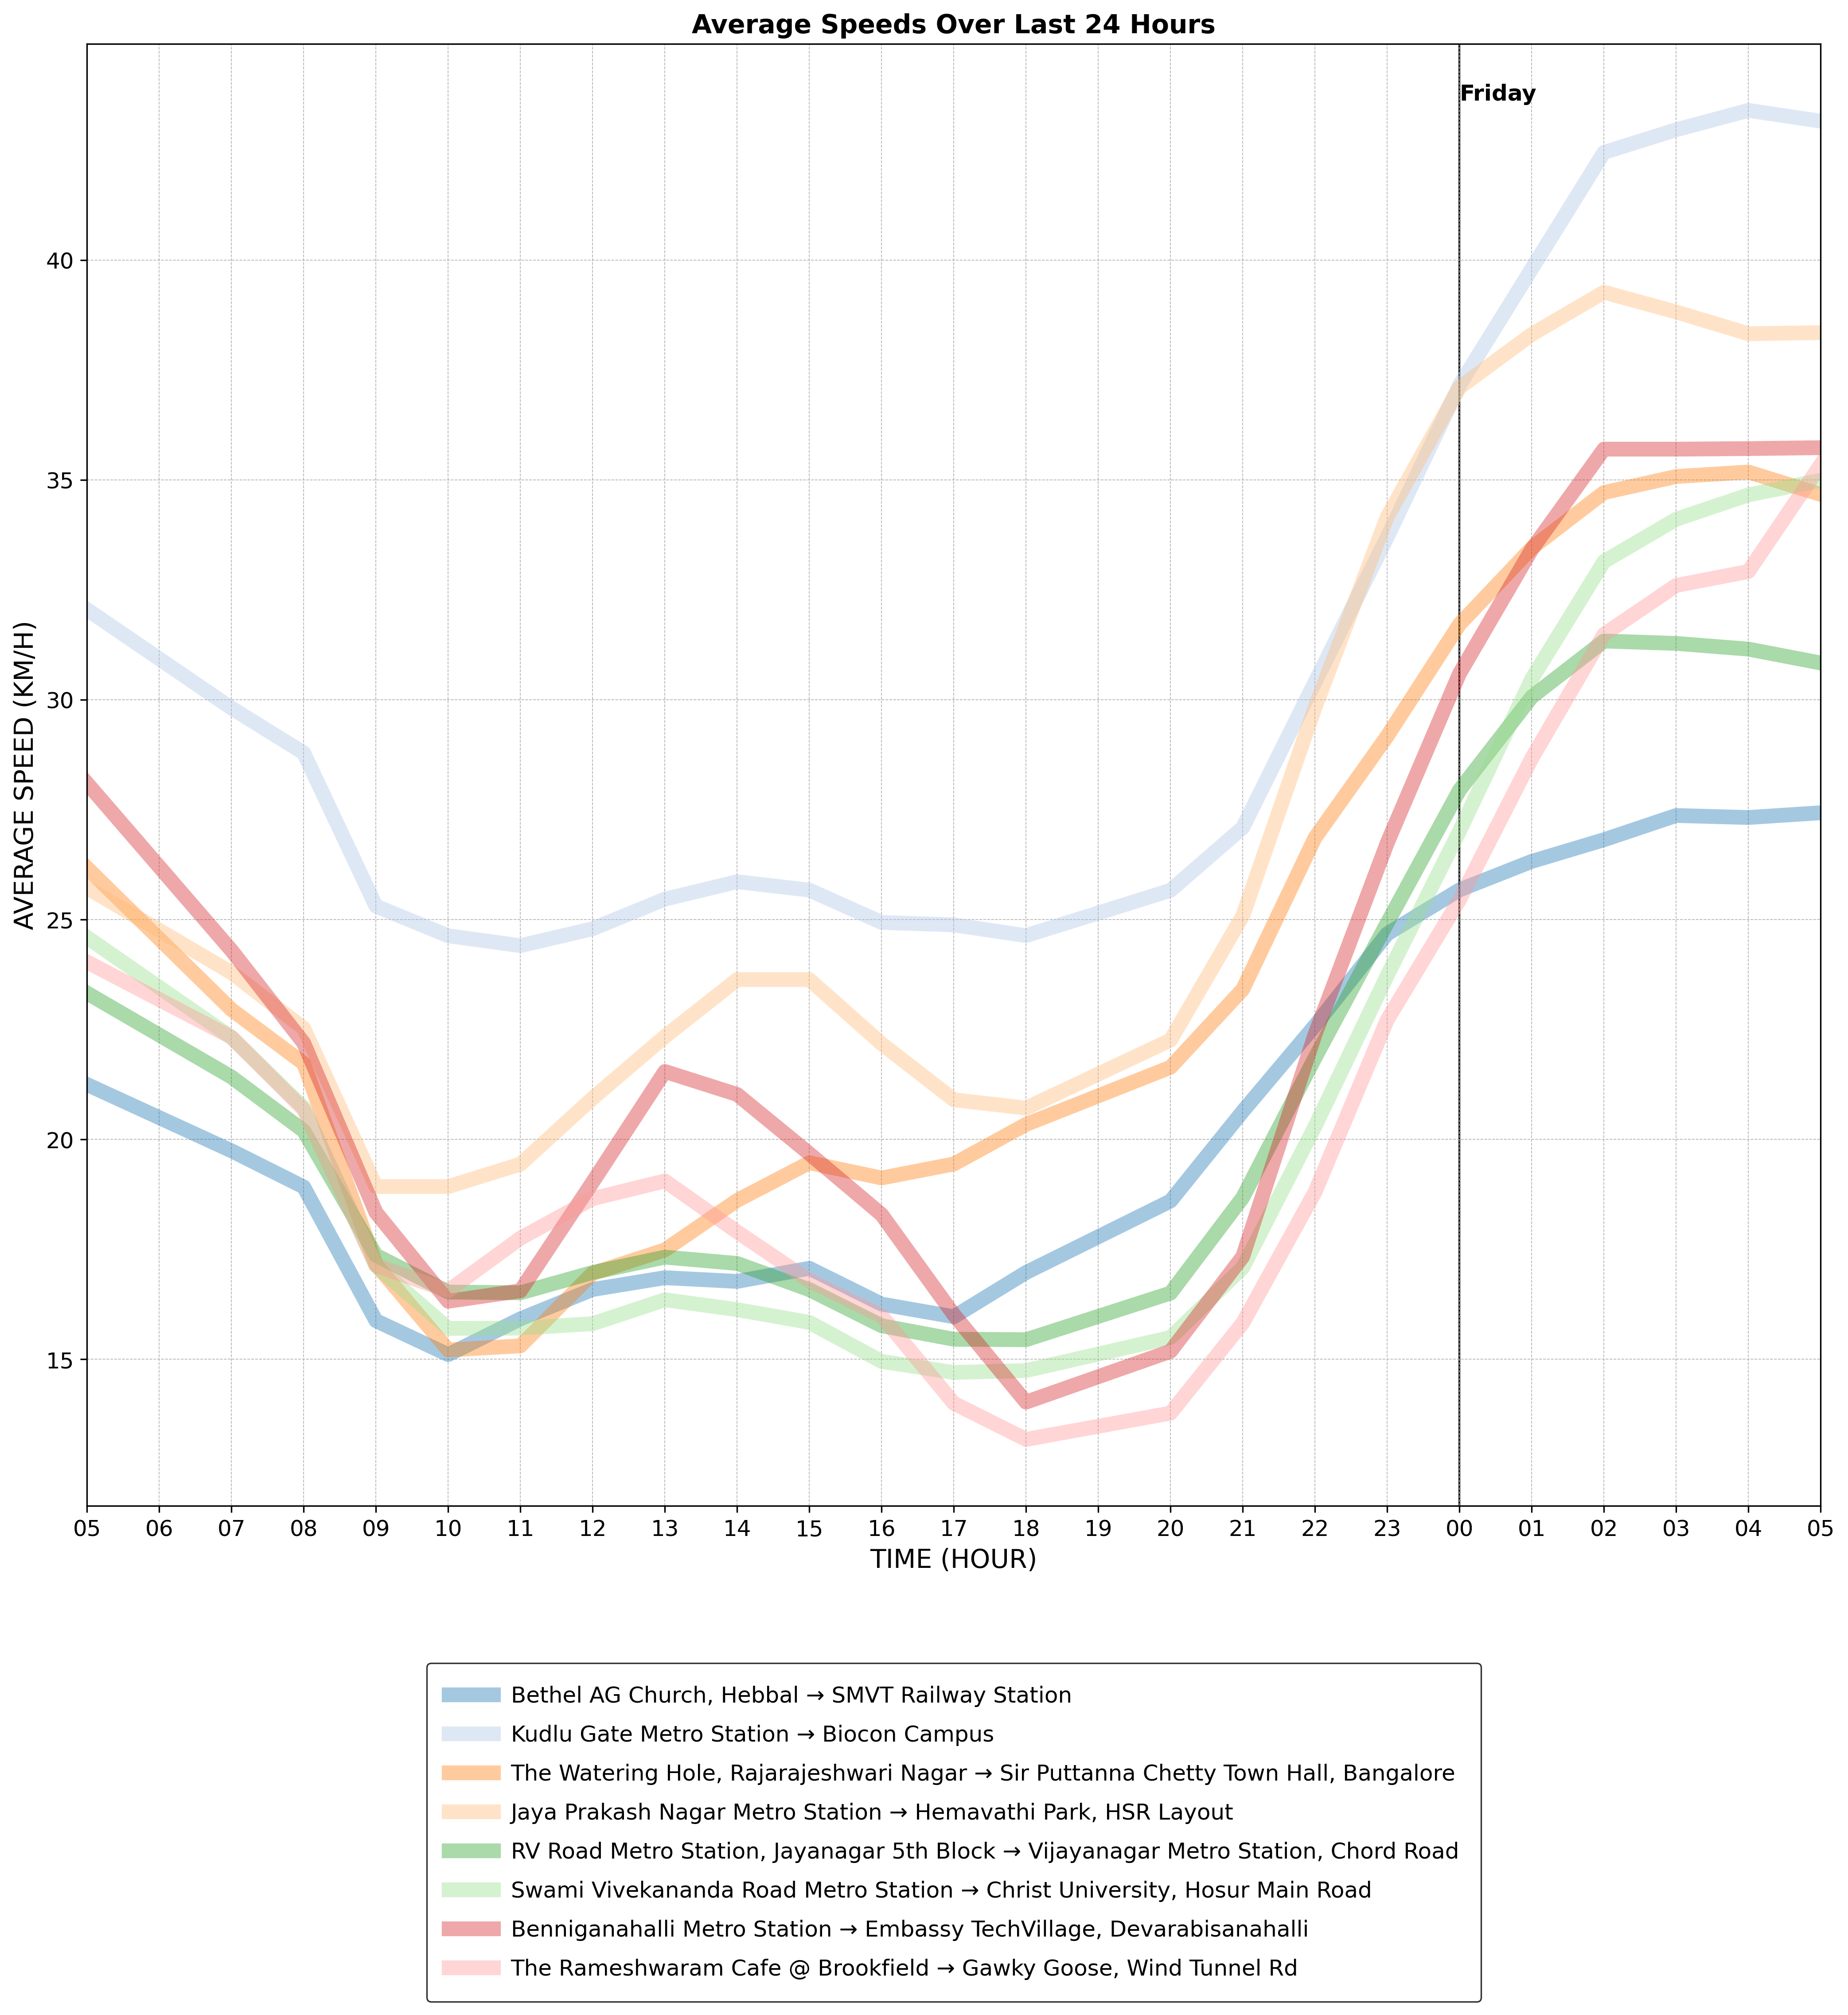

In [34]:
# [pd.to_datetime(df[['year', 'month', 'day']]) < '2025-10-10']
df_plot = plot_traffic_square(df, days_offset=1, label='full', height='square', dpi=300)

In [ ]:
plot_route_boxplots(
    plot_traffic_square(df, days_offset=1, label='short', height='square', dpi=300), 
            avg_speed=True, duration=True, legend=True)

_____
## Rolling Relative Route Scoring System (The R³S² Score)

In [ ]:
def get_variances(df):
    df_variance = df.copy()
    df_variance['avg_speed'] = df_variance['distance'] / df_variance['duration']
    df_variance = df_variance\
           .groupby(['route_code'])[['duration', 'distance', 'avg_speed']]\
           .agg(['min', 'mean', 'max'])\
           .reset_index()
    df_variance = df_variance.sort_values(by=[('avg_speed', 'mean')], ascending=[False])\
           .reset_index(drop=True)
    df_variance[[('duration', 'mean'), ('distance', 'mean'), ('avg_speed', 'mean')]]\
           = df_variance[[('duration', 'mean'), ('distance', 'mean'), ('avg_speed', 'mean')]].round(2)
    df_variance['points'] = np.linspace(len(df_variance)/2, -len(df_variance)/2, len(df_variance))
    return df_variance[['route_code', 'points']]


def calculate_rrs(df, ref_date=None, DAYS_ROLLING=10):
    if ref_date is None:
        ref_date = datetime.now()
    else:
        ref_date = datetime.strptime(ref_date, '%Y-%m-%d')
    df_rrs = pd.DataFrame({'route_code': df['route_code'].unique().tolist(), 
                           'points': [0]*len(df['route_code'].unique().tolist())})
    df_rrs = df_rrs.sort_values(by=['route_code']).reset_index(drop=True)
    for d in range(DAYS_ROLLING, 0, -1):
        filter = (df['date'] == (ref_date - timedelta(days=d)).strftime('%Y-%m-%d'))
        df_points = get_variances(df[filter])
        df_points = df_points.sort_values(by=['route_code']).reset_index(drop=True)
        df_rrs['points'] += df_points['points']
    df_rrs = df_rrs.sort_values(by=['points'], ascending=False).round(1).reset_index(drop=True)
    return df_rrs

df_rrs = calculate_rrs(df, DAYS_ROLLING=10).dropna()
df_rrs['route'] = df_rrs['route_code'].map(lambda x: locate(x.split('|')[0]) + '\u2192' + locate(x.split('|')[1]))
df_rrs = df_rrs[['route', 'points']]

display(df_rrs)

In [ ]:
# Create a color gradient - green (best) to red (worst)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(df_rrs)))

# Create figure with dark grid for better readability
plt.figure(figsize=(14, 10), dpi=300)
ax = plt.gca()

# Create horizontal bar chart
bars = ax.barh(range(len(df_rrs)), df_rrs['points'], color=colors, edgecolor='black', linewidth=0.5)

# Add value labels on the bars
for i, (idx, row) in enumerate(df_rrs.iterrows()):
    value = row['points']
    # Position label inside or outside bar depending on value
    x_pos = value - (abs(value) * 0.05) if value > 0 else value + (abs(value) * 0.05)
    ax.text(x_pos, i, f'{value}', ha='right' if value > 0 else 'left', 
            va='center', fontweight='normal', fontsize=12, color='#333333')

# Set y-axis labels (inverted so rank 1 is on top)
ax.set_yticks(range(len(df_rrs)))
ax.set_yticklabels(df_rrs['route'], fontsize=9)
ax.invert_yaxis()

# Add title and labels
ax.set_title('Rolling Relative Route Scoring System (R³S²)', ha='right',
             fontsize=20, fontweight='bold', pad=20, color='#2C3E50')
ax.set_xlabel('Performance Score (Higher = Faster Route)', fontsize=12, fontweight='bold', color='#34495E')
ax.set_ylabel('Route', fontsize=12, fontweight='bold', color='#34495E')

# Add subtitle with context
fig = plt.gcf()
fig.text(0.5, 0.96, f'10-Day Rolling Analysis • {len(df_rrs)} Routes Compared', 
         ha='center', fontsize=13, style='italic', color='#7F8C8D')

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Add a vertical line at zero
ax.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.5)

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Add a color legend
from matplotlib.patches import Rectangle
legend_x = 0.02
for i, label in enumerate(['Fastest Routes', 'Average Routes', 'Slowest Routes']):
    color_idx = int(i * (len(colors) - 1) / 2)
    fig.text(legend_x + i*0.15, 0.02, label, fontsize=10,
             bbox=dict(boxstyle='round,pad=0.4', facecolor=colors[color_idx], alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()